# MATHEMATICAL FOUNDATIONS OF ARTIFICIAL INTELLGENCE MS(AI)

# Linear Regression with OLS, SVD, Gradient Descent, and PCA

This notebook implements and compares different approaches for solving linear regression:

- **Task 1:** Dataset preparation (train/test split, scaling, bias term).
- **Task 2:** Ordinary Least Squares (OLS) via the normal equation.
- **Task 3:** SVD-based solution using the Moore–Penrose pseudoinverse.
- **Task 4:** Batch Gradient Descent optimization for mean squared error.
- **Task 5:** PCA-based dimensionality reduction and regression in reduced space.

The dataset is loaded from `sklearn.datasets` (`load_diabetes`), and all core algorithms
(OLS, SVD solution, Gradient Descent, PCA) are implemented manually using NumPy.


In [1]:
# === Imports and global configuration ===

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# Optional (for summary tables at the end)
import pandas as pd

# Reproducibility
np.random.seed(42)

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

# Figures directory (for saving plots for the report)
FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)

print("Setup complete.")


Setup complete.


## Task 1 – Dataset Preparation

We use the **Diabetes** dataset from `sklearn.datasets` as our regression dataset.

Steps:
1. Load the dataset using `load_diabetes`
2. Split into training and test sets.
3. Standardize features using training-set statistics (mean and std).
4. Add a bias (intercept) column to obtain the design matrices.
5. Briefly inspect the data (dimensions, feature names, basic statistics).


In [2]:
# === Load dataset and basic description ===

diabetes = load_diabetes()
X = diabetes.data           # shape (n_samples, n_features)
y = diabetes.target         # shape (n_samples,)
feature_names = diabetes.feature_names

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Feature names:", feature_names)
print()

print("First 5 targets:", y[:5])


Shape of X: (442, 10)
Shape of y: (442,)
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

First 5 targets: [151.  75. 141. 206. 135.]


In [3]:
# === Train/test split ===

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# === Standardization based on training set ===

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

# Avoid division by zero
X_std[X_std == 0] = 1.0

X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std


def add_bias(X):
    """
    Add a bias (intercept) column of ones as the first column.
    """
    return np.hstack([np.ones((X.shape[0], 1)), X])


X_train_design = add_bias(X_train_scaled)
X_test_design = add_bias(X_test_scaled)

print("Design matrix shape (train):", X_train_design.shape)
print("Design matrix shape (test):", X_test_design.shape)


Train shape: (353, 10) Test shape: (89, 10)
Design matrix shape (train): (353, 11)
Design matrix shape (test): (89, 11)


## Task 2 – Ordinary Least Squares (Normal Equation)

We implement the OLS solution using the normal equation:
```
β̂ = (XᵀX)⁻¹Xᵀy
```

**Where:**
- `X ∈ ℝⁿˣ⁽ᵈ⁺¹⁾` is the design matrix with a bias column
- `y ∈ ℝⁿ` is the target vector
- `β̂ ∈ ℝᵈ⁺¹` are the regression coefficients

**We will:**
1. Implement OLS via the normal equation using NumPy
2. Compute train and test MSE
3. Plot residuals to visually inspect the fit
4. Briefly discuss when the normal equation can fail (ill-conditioning, singular matrices)

In [4]:
# === Utility functions: MSE, prediction, OLS normal equation ===

def mse(y_true, y_pred):
    """
    Mean Squared Error.
    """
    return np.mean((y_true - y_pred) ** 2)


def predict(X, beta):
    """
    Linear prediction: y_hat = X @ beta
    """
    return X @ beta


def ols_normal_equation(X, y):
    """
    OLS using the normal equation:
        beta = (X^T X)^(-1) X^T y
    """
    XtX = X.T @ X
    Xty = X.T @ y

    # Inverse (can be unstable for ill-conditioned XtX)
    beta = np.linalg.inv(XtX) @ Xty
    return beta


OLS coefficients shape: (11,)
OLS train MSE: 2868.549702835577
OLS test  MSE: 2900.1936284934795


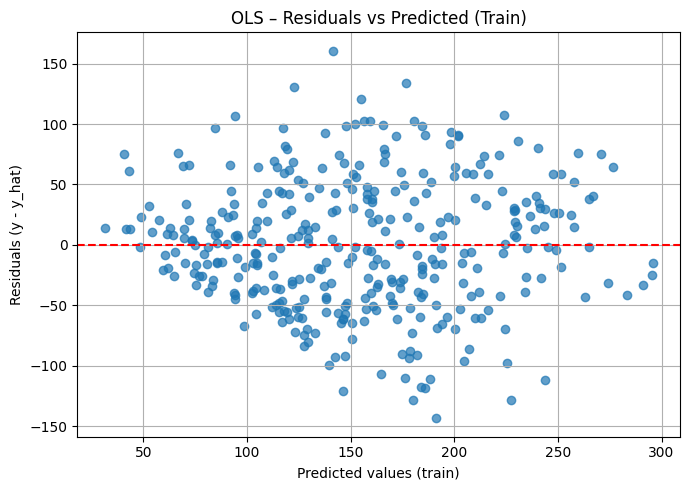

In [5]:
# === Fit OLS on training data ===

beta_ols = ols_normal_equation(X_train_design, y_train)

y_train_pred_ols = predict(X_train_design, beta_ols)
y_test_pred_ols = predict(X_test_design, beta_ols)

mse_train_ols = mse(y_train, y_train_pred_ols)
mse_test_ols = mse(y_test, y_test_pred_ols)

print("OLS coefficients shape:", beta_ols.shape)
print("OLS train MSE:", mse_train_ols)
print("OLS test  MSE:", mse_test_ols)

# === Residual plot on training set ===

residuals_train = y_train - y_train_pred_ols

plt.figure()
plt.scatter(y_train_pred_ols, residuals_train, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values (train)")
plt.ylabel("Residuals (y - y_hat)")
plt.title("OLS – Residuals vs Predicted (Train)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "ols_residuals_train.png", bbox_inches="tight")
plt.show()


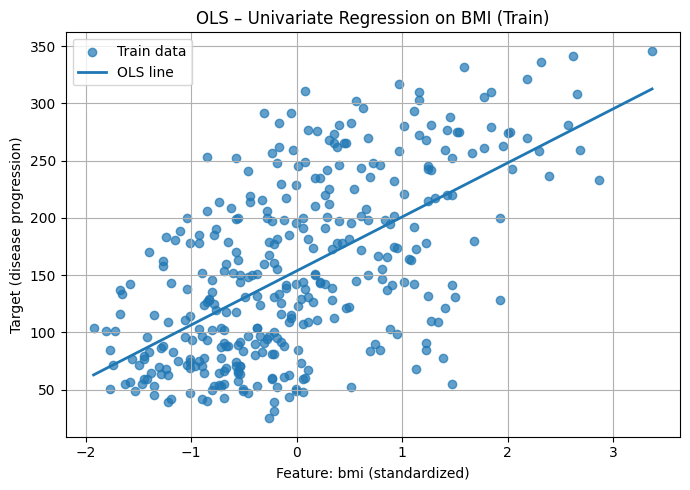

In [6]:
# === Optional: 1D regression visualization for one feature (e.g., BMI) ===

# We'll pick feature index corresponding to 'bmi'
feature_list = list(feature_names)
if "bmi" in feature_list:
    bmi_idx = feature_list.index("bmi")
else:
    bmi_idx = 0  # fallback

X_train_bmi = X_train_scaled[:, [bmi_idx]]  # shape (n_train, 1)
X_test_bmi = X_test_scaled[:, [bmi_idx]]

X_train_bmi_design = add_bias(X_train_bmi)
X_test_bmi_design = add_bias(X_test_bmi)

beta_ols_bmi = ols_normal_equation(X_train_bmi_design, y_train)

# Plot: BMI vs target with regression line
plt.figure()
plt.scatter(X_train_bmi[:, 0], y_train, alpha=0.7, label="Train data")

# Sort for line plot
sorted_idx = np.argsort(X_train_bmi[:, 0])
x_sorted = X_train_bmi[sorted_idx, 0]
y_line = predict(X_train_bmi_design, beta_ols_bmi)[sorted_idx]

plt.plot(x_sorted, y_line, label="OLS line", linewidth=2)
plt.xlabel(f"Feature: {feature_list[bmi_idx]} (standardized)")
plt.ylabel("Target (disease progression)")
plt.title("OLS – Univariate Regression on BMI (Train)")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "ols_univariate_bmi.png", bbox_inches="tight")
plt.show()


### Discussion: When the Normal Equation Can Fail

The normal equation `β̂ = (XᵀX)⁻¹Xᵀy` requires computing the inverse of `XᵀX`. This operation can fail or become unstable in several scenarios:

**1. Singular Matrix**
- `XᵀX` is not invertible
- Occurs when features are duplicated or perfectly correlated
- Results in no unique solution

**2. Ill-Conditioned Matrix**
- `XᵀX` is nearly singular (very large condition number)
- Leads to numerical instability and large errors in `β̂`
- Small changes in data cause large changes in coefficients

**3. High-Dimensional Setting**
- Number of features is large compared to number of samples
- Increases likelihood of numerical issues
- Matrix inversion becomes computationally expensive and unstable

**Solution:** Use **SVD-based pseudoinverse**, which is numerically more stable and allows us to truncate small singular values, effectively handling ill-conditioned matrices.

## Task 3 – SVD-Based Solution (Pseudoinverse)

We compute the SVD of the design matrix:
```
X = UΣVᵀ
```

Then the Moore–Penrose pseudoinverse of `X` is:
```
X⁺ = VΣ⁺Uᵀ
```
where `Σ⁺` is obtained by inverting the non-zero singular values.

The regression solution is:
```
β̂ = X⁺y
```

**We will:**
1. Implement the SVD-based pseudoinverse solution for regression
2. Compute train/test MSE and compare to OLS
3. Plot the singular values of the design matrix
4. Demonstrate robustness under an ill-conditioned example

SVD train MSE: 2868.5497028355776
SVD test  MSE: 2900.1936284934827
||beta_ols - beta_svd||_2 = 2.478673581372636e-12


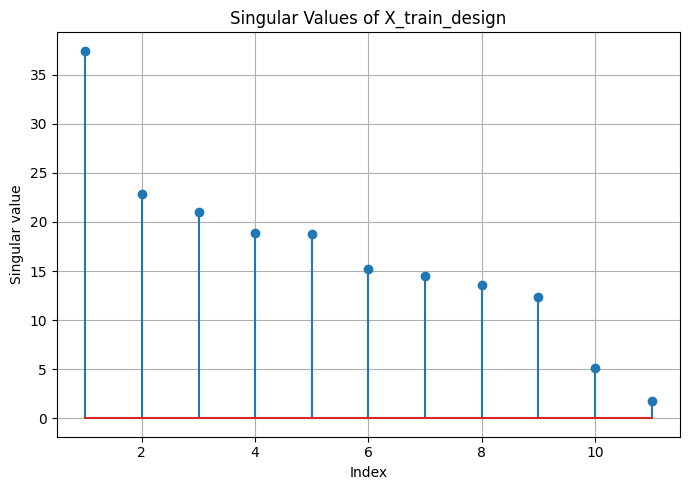

In [7]:
# === SVD-based pseudoinverse regression ===

def svd_pseudoinverse_solution(X, y, tol=1e-10):
    """
    Solve linear regression using SVD-based pseudoinverse.
    X: design matrix (n x d)
    y: target (n,)
    tol: threshold for treating singular values as zero
    """
    U, S, VT = np.linalg.svd(X, full_matrices=False)
    S_inv = np.array([1/s if s > tol else 0.0 for s in S])
    Sigma_plus = np.diag(S_inv)

    X_pinv = VT.T @ Sigma_plus @ U.T
    beta = X_pinv @ y
    return beta, S


beta_svd, singular_values = svd_pseudoinverse_solution(X_train_design, y_train)

y_train_pred_svd = predict(X_train_design, beta_svd)
y_test_pred_svd = predict(X_test_design, beta_svd)

mse_train_svd = mse(y_train, y_train_pred_svd)
mse_test_svd = mse(y_test, y_test_pred_svd)

print("SVD train MSE:", mse_train_svd)
print("SVD test  MSE:", mse_test_svd)

# Difference between OLS and SVD coefficients
coef_diff_norm = np.linalg.norm(beta_ols - beta_svd)
print("||beta_ols - beta_svd||_2 =", coef_diff_norm)

# === Plot singular values ===
# === Plot singular values ===
plt.figure()
plt.stem(range(1, len(singular_values) + 1), singular_values)
plt.xlabel("Index")
plt.ylabel("Singular value")
plt.title("Singular Values of X_train_design")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "svd_singular_values.png", bbox_inches="tight")
plt.show()



In [8]:
# === Ill-conditioned example: duplicate / nearly duplicate column ===

# Create a near-duplicate of one column (e.g., column 2 in X_train_design)
col_idx = 2  # arbitrary
duplicate_column = X_train_design[:, [col_idx]] * 1.000001

X_train_ill = np.hstack([X_train_design, duplicate_column])

print("Ill-conditioned design matrix shape:", X_train_ill.shape)

# Attempt OLS on ill-conditioned matrix
try:
    beta_ols_ill = ols_normal_equation(X_train_ill, y_train)
    print("OLS (ill-conditioned) succeeded.")
except np.linalg.LinAlgError as e:
    print("OLS (ill-conditioned) failed with error:", e)
    beta_ols_ill = None

# SVD solution with small-value truncation
beta_svd_ill, S_ill = svd_pseudoinverse_solution(X_train_ill, y_train, tol=1e-8)

print("Singular values (ill-conditioned):", S_ill)

# If OLS succeeded, compare coefficients
if beta_ols_ill is not None:
    diff_ill = np.linalg.norm(beta_ols_ill - beta_svd_ill)
    print("||beta_ols_ill - beta_svd_ill||_2 =", diff_ill)

# Note: Numerically, SVD remains stable while OLS can be unstable or fail.


Ill-conditioned design matrix shape: (353, 12)
OLS (ill-conditioned) succeeded.
Singular values (ill-conditioned): [3.81065085e+01 2.66730121e+01 2.13333703e+01 2.07777267e+01
 1.87882942e+01 1.56115533e+01 1.44849158e+01 1.35535479e+01
 1.28615100e+01 5.16807421e+00 1.80528579e+00 1.91278536e-15]
||beta_ols_ill - beta_svd_ill||_2 = 12.882642874771511


## Task 4 – Gradient Descent for Linear Regression

We minimize the mean squared error (MSE) using **batch gradient descent**.

**Define the loss:**
```
L(β) = (1/2n)||Xβ - y||²
```

**The gradient is:**
```
∇_β L(β) = (1/n)Xᵀ(Xβ - y)
```

**We will:**
1. Implement batch gradient descent
2. Experiment with different learning rates
3. Plot the loss curve over iterations
4. Compare the solution and MSE with the analytical OLS/SVD solutions

In [9]:
# === Loss and Gradient for MSE ===

def compute_loss(X, y, beta):
    """
    L(beta) = (1 / (2n)) * ||X beta - y||^2
    """
    n = X.shape[0]
    residuals = X @ beta - y
    return 0.5 / n * np.dot(residuals, residuals)


def compute_gradient(X, y, beta):
    """
    ∇L(beta) = (1 / n) * X^T (X beta - y)
    """
    n = X.shape[0]
    residuals = X @ beta - y
    grad = (X.T @ residuals) / n
    return grad


def gradient_descent(X, y, lr=0.01, n_iters=1000, beta_init=None):
    """
    Batch gradient descent for linear regression.
    Returns the final beta and the loss history.
    """
    n_samples, n_features = X.shape

    if beta_init is None:
        beta = np.zeros(n_features)
    else:
        beta = beta_init.copy()

    losses = []

    for k in range(n_iters):
        grad = compute_gradient(X, y, beta)
        beta = beta - lr * grad
        loss = compute_loss(X, y, beta)
        losses.append(loss)

    return beta, np.array(losses)


LR=0.0001: final train loss = 9986.5961
LR= 0.001: final train loss = 1677.8122
LR=  0.01: final train loss = 1445.1551
LR=   0.1: final train loss = 1434.6660


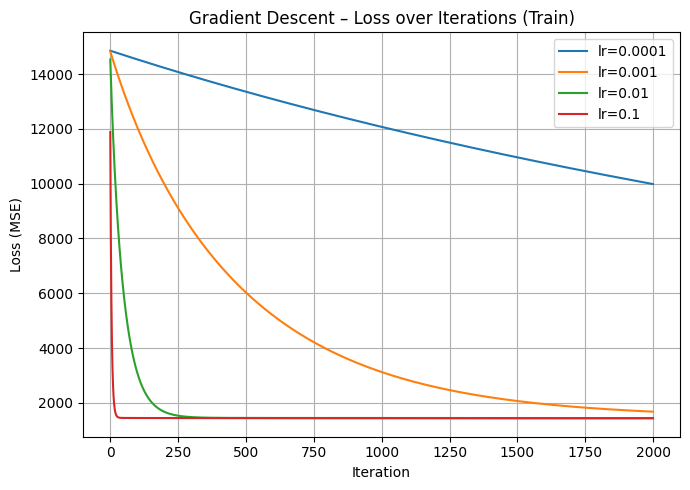

In [10]:
# === Experiment with different learning rates ===

learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
n_iters = 2000

gd_results = {}  # lr -> (beta, losses)

for lr in learning_rates:
    beta_gd, loss_curve = gradient_descent(X_train_design, y_train, lr=lr, n_iters=n_iters)
    gd_results[lr] = (beta_gd, loss_curve)
    print(f"LR={lr:>6}: final train loss = {loss_curve[-1]:.4f}")

# Plot loss curves
plt.figure()
for lr in learning_rates:
    _, loss_curve = gd_results[lr]
    plt.plot(loss_curve, label=f"lr={lr}")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Gradient Descent – Loss over Iterations (Train)")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "gd_loss_curves.png", bbox_inches="tight")
plt.show()


In [11]:
# === Choose the best learning rate based on final training loss ===

best_lr = None
best_final_loss = float("inf")

for lr, (_, loss_curve) in gd_results.items():
    if loss_curve[-1] < best_final_loss:
        best_final_loss = loss_curve[-1]
        best_lr = lr

print("Best learning rate (by final train loss):", best_lr)

beta_gd_best, loss_curve_best = gd_results[best_lr]

# Evaluate on train and test
y_train_pred_gd = predict(X_train_design, beta_gd_best)
y_test_pred_gd = predict(X_test_design, beta_gd_best)

mse_train_gd = mse(y_train, y_train_pred_gd)
mse_test_gd = mse(y_test, y_test_pred_gd)

print("GD (best lr) train MSE:", mse_train_gd)
print("GD (best lr) test  MSE:", mse_test_gd)

# Compare coefficients with OLS
coef_diff_gd_ols = np.linalg.norm(beta_gd_best - beta_ols)
print("||beta_gd_best - beta_ols||_2 =", coef_diff_gd_ols)


Best learning rate (by final train loss): 0.1
GD (best lr) train MSE: 2869.332030772073
GD (best lr) test  MSE: 2895.3001479082754
||beta_gd_best - beta_ols||_2 = 9.205259777384192


## Task 5 – PCA and Dimensionality Reduction

We use **SVD** to compute the principal components of the (standardized) training data.

Steps:
1. Compute SVD of the training data (without bias column).
2. Derive eigenvalues and explained variance ratios.
3. Plot the variance explained (scree plot and cumulative).
4. For each \(k\), project data onto the top-\(k\) principal components.
5. Run regression on the reduced data (using OLS).
6. Plot test error vs. \(k\) and discuss the trade-off between dimensionality and performance.


In [12]:
# === PCA via SVD on standardized training data (without bias) ===

# X_train_scaled is already standardized with zero mean per feature.
Xc = X_train_scaled  # zero-mean approx.

U_pca, S_pca, VT_pca = np.linalg.svd(Xc, full_matrices=False)

# Eigenvalues of covariance matrix: lambda_i = S_i^2 / (n-1)
n_train = Xc.shape[0]
eigenvalues = (S_pca ** 2) / (n_train - 1)
total_variance = eigenvalues.sum()
explained_variance_ratio = eigenvalues / total_variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print("Eigenvalues:", eigenvalues)
print("Explained variance ratio:", explained_variance_ratio)
print("Cumulative explained variance:", cumulative_explained_variance)


Eigenvalues: [3.98008581 1.48217279 1.25521605 1.0137426  0.66015985 0.59519632
 0.52184481 0.43488224 0.07584994 0.00925867]
Explained variance ratio: [0.39688108 0.1477974  0.12516602 0.10108708 0.06582897 0.05935102
 0.05203665 0.04336503 0.00756351 0.00092324]
Cumulative explained variance: [0.39688108 0.54467848 0.6698445  0.77093158 0.83676055 0.89611157
 0.94814822 0.99151325 0.99907676 1.        ]


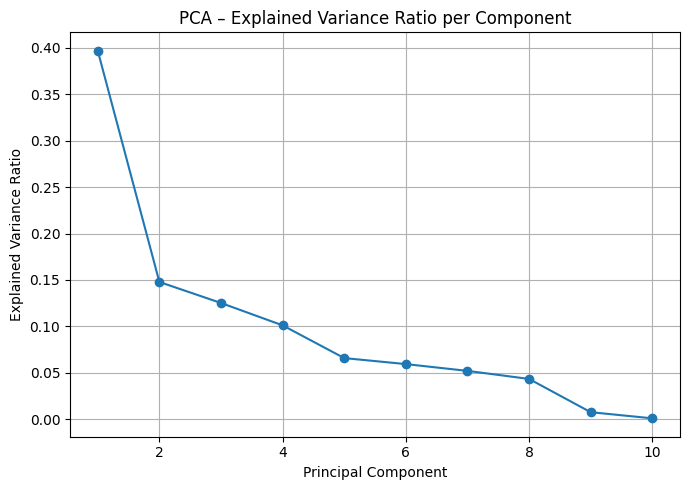

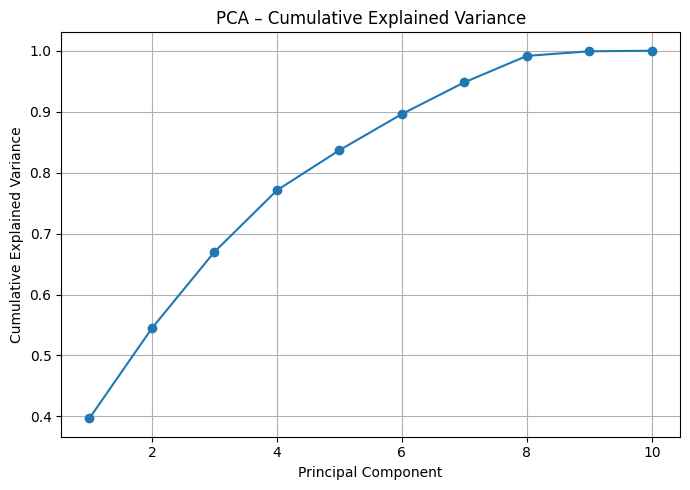

In [13]:
# === Scree plot (variance explained) ===

components = np.arange(1, len(eigenvalues) + 1)

plt.figure()
plt.plot(components, explained_variance_ratio, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA – Explained Variance Ratio per Component")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca_explained_variance.png", bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(components, cumulative_explained_variance, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA – Cumulative Explained Variance")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca_cumulative_variance.png", bbox_inches="tight")
plt.show()


In [14]:
# === Projection onto top-k principal components ===

def project_onto_pcs(X_scaled, VT, k):
    """
    Project standardized data X_scaled onto top-k principal components.
    VT: matrix from SVD with principal directions in rows.
    """
    W_k = VT[:k].T  # shape (n_features, k)
    return X_scaled @ W_k


# Evaluate regression performance for different k
max_k = X_train_scaled.shape[1]  # up to number of original features
k_values = list(range(1, max_k + 1))

test_mse_pca = []
train_mse_pca = []

for k in k_values:
    Z_train_k = project_onto_pcs(X_train_scaled, VT_pca, k)
    Z_test_k = project_onto_pcs(X_test_scaled, VT_pca, k)

    Z_train_design_k = add_bias(Z_train_k)
    Z_test_design_k = add_bias(Z_test_k)

    beta_pca_k = ols_normal_equation(Z_train_design_k, y_train)

    y_train_pred_pca_k = predict(Z_train_design_k, beta_pca_k)
    y_test_pred_pca_k = predict(Z_test_design_k, beta_pca_k)

    train_mse = mse(y_train, y_train_pred_pca_k)
    test_mse = mse(y_test, y_test_pred_pca_k)

    train_mse_pca.append(train_mse)
    test_mse_pca.append(test_mse)

# Convert to numpy arrays for convenience
train_mse_pca = np.array(train_mse_pca)
test_mse_pca = np.array(test_mse_pca)

# Find best k based on test MSE
best_k_idx = np.argmin(test_mse_pca)
best_k = k_values[best_k_idx]

print("Best k (by test MSE):", best_k)
print("Train MSE at best k:", train_mse_pca[best_k_idx])
print("Test  MSE at best k:", test_mse_pca[best_k_idx])


Best k (by test MSE): 4
Train MSE at best k: 3005.81564329027
Test  MSE at best k: 2874.1781343874186


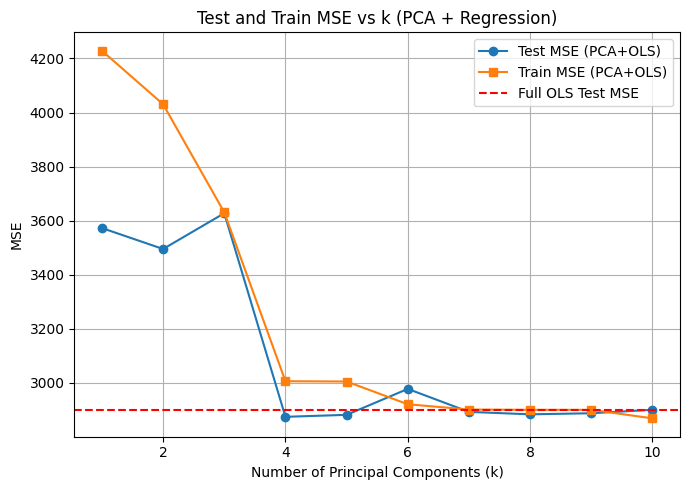

In [15]:
# === Plot error vs k ===

plt.figure()
plt.plot(k_values, test_mse_pca, marker="o", label="Test MSE (PCA+OLS)")
plt.plot(k_values, train_mse_pca, marker="s", label="Train MSE (PCA+OLS)")
plt.axhline(mse_test_ols, color="red", linestyle="--", label="Full OLS Test MSE")
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("MSE")
plt.title("Test and Train MSE vs k (PCA + Regression)")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca_error_vs_k.png", bbox_inches="tight")
plt.show()


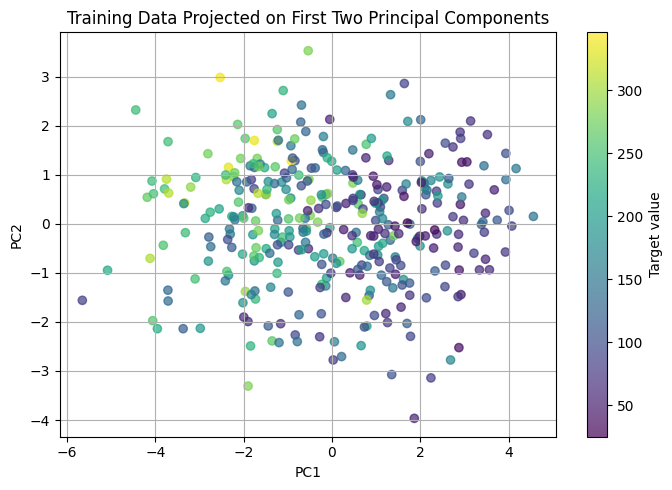

In [16]:
# === Optional: 2D scatter on first two principal components ===

Z_train_2 = project_onto_pcs(X_train_scaled, VT_pca, 2)

plt.figure()
scatter = plt.scatter(Z_train_2[:, 0], Z_train_2[:, 1], c=y_train, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Training Data Projected on First Two Principal Components")
plt.colorbar(scatter, label="Target value")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca_2d_scatter.png", bbox_inches="tight")
plt.show()


In [17]:
# === Summary comparison of methods ===

# For PCA, use the best_k we found
best_k_idx = np.argmin(test_mse_pca)
best_k = k_values[best_k_idx]

summary_data = {
    "Method": [
        "OLS (Normal Equation)",
        "SVD Pseudoinverse",
        f"Gradient Descent (lr={best_lr})",
        f"PCA + OLS (k={best_k})",
    ],
    "Train MSE": [
        mse_train_ols,
        mse_train_svd,
        mse_train_gd,
        train_mse_pca[best_k_idx],
    ],
    "Test MSE": [
        mse_test_ols,
        mse_test_svd,
        mse_test_gd,
        test_mse_pca[best_k_idx],
    ],
}

summary_df = pd.DataFrame(summary_data)
summary_df


,Method,Train MSE,Test MSE
0,OLS (Normal Equation),2868.549703,2900.193628
1,SVD Pseudoinverse,2868.549703,2900.193628
2,Gradient Descent (lr=0.1),2869.332031,2895.300148
3,PCA + OLS (k=4),3005.815643,2874.178134


## Conclusions and Notes for Report

- **OLS vs SVD:**
  - On this dataset, OLS and SVD-based solutions yield nearly identical coefficients and MSE.
  - SVD is more numerically stable and handles ill-conditioned cases more robustly.

- **Gradient Descent:**
  - With a suitable learning rate, gradient descent converges close to the analytical solution.
  - Too small learning rates converge slowly; too large can cause divergence.
  - Computationally, closed-form solutions (OLS/SVD) are fast for small to medium datasets,
    while gradient-based methods scale better to very large datasets.

- **PCA + Regression:**
  - Using PCA reduces dimensionality and can improve generalization if we discard noisy components.
  - The test MSE as a function of \(k\) shows how performance changes with the number of components.
  - There is a trade-off between **dimensionality** and **performance** (bias–variance trade-off).

These results and plots can be directly used in the written report, together with brief
theoretical explanations of each method (OLS, SVD, GD, PCA) and a discussion of numerical stability and model performance.